In [701]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Using Deep Learning to predict Rossmann store sales

*by Johannes Bock, 21 October 2017*

Most of the focus in the deep learning community is around computer-vision and NLP tasks, which mostly deal with unstructured data. However, most of the data in industry is structured data and to my knowledge only little effort has been made to develop successful neural network architectures for these practical structured data problems.

In the following notebook I will apply deep learning to a real-world business problem using structured data. To achieve state-of-the-art performance I will implement my version of the [Entity Embeddings model](https://arxiv.org/abs/1604.06737) proposed by Guo and Berkhahn (2016) in the [Rossman competition on Kaggle](https://www.kaggle.com/c/rossmann-store-sales). Their approach is a very interesting idea inspired by semantic embeddings from the natural language processing domain (also see: [Distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics), [Word embedding](https://en.wikipedia.org/wiki/Word_embedding) or [Word2vec](https://en.wikipedia.org/wiki/Word2vec)).

**Project overview**

To achieve state-of-the-art performance on this prediction problem I will go through the following steps (not necessarily in that strict order, but rather iteratively):

1. Load & merge multiple data sources
1. Data pre-processing
    * Explore & transform the target variable
    * Missing data
    * Data scaling and normalization
    * Feature encoding
    * Feature engineering & selection
2. Deep Learning model definition
3. Model training
4. Bayesian hyperparameter tuning
5. Model ensembling
6. Model evaluation & testing
7. Model inspection
    * Visualize learned entity embeddings

## Rossmann store sales data

The training data is being provided on the [Kaggle platform](https://www.kaggle.com/c/rossmann-store-sales/data). The dataset contains daily data over a period of a little bit less than 3 years for 1,115 Rossmann stores located across Germany. The challenge is to forecast daily store sales for each individual store. As store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality, the dataset contains about 45 features to account for these. In addition to the provided data, I will be using external datasets put together by participants in the Kaggle competition (i.e. Google search data, weather data etc.).

### Load and merge datasets

Since multiple data sources for weather, google search or competition data will be used, I will first merge all of them into one single dataframe.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime

#notebook seetings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_style("white")

#general variables
rnd_state = 0
np.random.seed(rnd_state)
target = "Sales"

#import the data
dat = pd.read_csv("data/train.csv",delimiter=",",parse_dates = ["Date"]) #encoding = "ISO-8859-1"
store_state = pd.read_csv("data/store_states.csv",delimiter=",")
state_name = pd.read_csv("data/state_names.csv",delimiter=",")
additional_store = pd.read_csv("data/store.csv",delimiter=",")

google = pd.read_csv("data/googletrend.csv",delimiter=",")
weather = pd.read_csv("data/weather.csv",delimiter=",",parse_dates = ["Date"])

#Merge datasets into one
store = store_state.merge(state_name,on = "State", how = "left", copy=False)
dat = dat.merge(store, on = "Store", how = "left", copy=False)
dat = dat.merge(additional_store, on="Store",how = "left", copy = False)

# Split the date column into its parts
dat["Day"] = dat["Date"].dt.day
dat["Month"] = dat["Date"].dt.month
dat["Year"] = dat["Date"].dt.year

#keys for google data: ["Week","Year", State"]
google["Date"] = pd.to_datetime(google.week.str.split(' - ', expand=True)[1])
google["Week"] = google["Date"].dt.week
google["Year"] = google["Date"].dt.year
google["State"] = google.file.str.split('_', expand=True)[2]
google.loc[google.State=="NI", "State"] = "HB,NI"

dat["Week"] = (dat["Date"]+datetime.timedelta(days=1)).dt.week #

# Merge Google and weather data in
dat = dat.merge(google, on=["Week","Year","State"],how = "left", copy = False,suffixes=("", "_y"))
dat = dat.drop(["file","week","Date_y"],axis=1)
dat.rename(columns={'trend':'trend_specific'}, inplace=True)

#keys germany-wide trend: "Week","Year"
dat = dat.merge(google[google["file"]=="Rossmann_DE"], on=["Week","Year"],how = "left", copy = False,suffixes=("", "_y"))

#keys for weather data: ["Date","StateName"]
weather.rename(columns={'file':'StateName'}, inplace=True)
dat = dat.merge(weather, on=["Date","StateName"],how = "left", copy = False,suffixes=("", "_y"))
dat.index = dat["Date"]
dat.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,State,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015-07-31,5263,555,1,1,0,1,HE,...,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13
2015-07-31,2,5,2015-07-31,6064,625,1,1,0,1,TH,...,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309
2015-07-31,3,5,2015-07-31,8314,821,1,1,0,1,NW,...,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354
2015-07-31,4,5,2015-07-31,13995,1498,1,1,0,1,BE,...,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282
2015-07-31,5,5,2015-07-31,4822,559,1,1,0,1,SN,...,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290


In [3]:
#Drop some columns which are not being used
drop_cols = ["State","file","week","Date_y","State_y"]
dat = dat.drop(drop_cols,axis=1)
print(dat.shape)

(1017209, 47)


The dataset contains a total of *1,017,209 observations* and *46 raw features* plus target variable. It includes both categorical and numeric variables, which will be pre-processed appropriately.

### Target variable

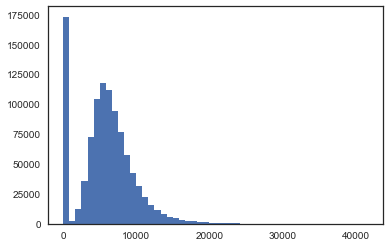

In [4]:
plt.hist(dat[target],bins = 50)
plt.show()

The target variable is daily store **sales**, which is slightly skewed as it is shown above. Moreover, the data contains some observations with zero sales. These were days, when the Rossmann stores were either temporarily closed for refurbishment or holidays.

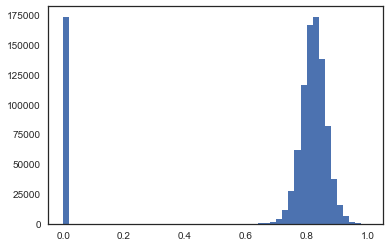

In [5]:
#Scale target
max_log_y = np.max(np.log(dat[target]))
dat.loc[dat[target]!=0,target] = np.log(dat.loc[dat[target]!=0,target])/max_log_y 
plt.hist(dat[target],bins = 50)
plt.show()

In order to have a nicer target distribution for the deep learning model, the sales data is being log transformed and normalized.

### Missing data

**Number of missing records:**

In [6]:
missing = dat.isnull().sum()
missing[missing != 0]

CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Max_VisibilityKm              24645
Mean_VisibilityKm             24645
Min_VisibilitykM              24645
Max_Gust_SpeedKm_h           781042
CloudCover                    80319
Events                       242248
dtype: int64

The data fields above contain quite a few missing records. For most of the variables I will simply replace the missing record with a dummy value. Later, the model will learn how to deal with the dummy entries.

The weather variables *Max_Gust_SpeedKm_h and VisibilityKm * will be dropped since they are deemed not to be very useful or contain no data for most of the observations.

In [7]:
drop_cols = ["Max_Gust_SpeedKm_h","Max_VisibilityKm","Mean_VisibilityKm","Min_VisibilitykM"]
dat = dat.drop(drop_cols,axis=1)

In [8]:
#Replace missing values with dummy values
dat.CompetitionOpenSinceYear = dat.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
dat.CompetitionOpenSinceMonth = dat.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
dat.Promo2SinceYear = dat.Promo2SinceYear.fillna(1900).astype(np.int32)
dat.Promo2SinceWeek = dat.Promo2SinceWeek.fillna(1).astype(np.int32)

dat.CompetitionDistance = dat.CompetitionDistance.fillna(0.)
dat.PromoInterval = dat.PromoInterval.astype(str)
dat.Events = dat.Events.astype(str)
dat.CloudCover = dat.CloudCover.fillna(-1.)

missing = dat.isnull().sum()

### Feature engineering

#### Transform ambiguous date features

In [9]:
columns = ["Store","Date", "Promo2SinceWeek","Promo2SinceYear",
           "CompetitionOpenSinceMonth","CompetitionOpenSinceYear"]
dat[columns].head()

,Store,Date,Promo2SinceWeek,Promo2SinceYear,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
Date,,,,,,
2015-07-31,1,2015-07-31,1,1900,9,2008
2015-07-31,2,2015-07-31,13,2010,11,2007
2015-07-31,3,2015-07-31,14,2011,12,2006
2015-07-31,4,2015-07-31,1,1900,9,2009
2015-07-31,5,2015-07-31,1,1900,4,2015


The promotion and the competition features are ambiguous as they contain only a date reference. The model will more easily learn patterns if these features are being transformed into meaningful counts using the data above. The following new features will be created:

* Promo2Weeks
* CompetitionMonthsOpen

In [10]:
dat["Promo2Since"] = pd.to_datetime(dat.apply(lambda x: datetime.datetime.strptime(str(x.Promo2SinceYear)+" "+str(x.Promo2SinceWeek) + " 0", "%Y %W %w"), axis=1).astype(pd.datetime))
dat["Promo2Days"] = dat.Date.subtract(dat["Promo2Since"]).dt.days

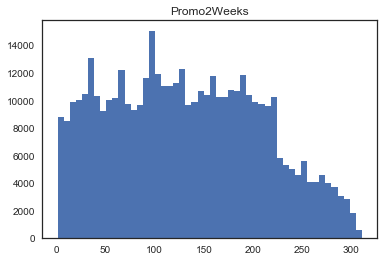

In [11]:
dat.loc[dat.Promo2Days<0, "Promo2Days"] = 0
dat.loc[dat.Promo2SinceYear<1990, "Promo2Days"] = 0
dat["Promo2Weeks"] = dat["Promo2Days"]//7
dat.loc[dat.Promo2Weeks<0, "Promo2Weeks"] = 0

plt.hist(dat.loc[dat["Promo2Weeks"]>0,"Promo2Weeks"],bins=50)
plt.title("Promo2Weeks")
plt.show()

The historgram above shows the distribution of the new feature *Promo2Weeks* which indicates the number of weeks for which a certain promotion has been in place. 

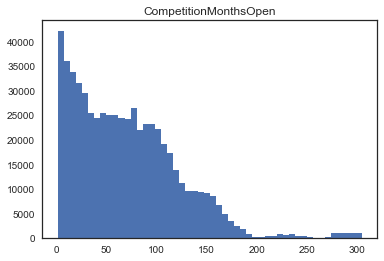

In [12]:
dat["CompetitionOpenSince"] = pd.to_datetime(dat.apply(lambda x: datetime.datetime(x.CompetitionOpenSinceYear,x.CompetitionOpenSinceMonth,15), axis=1).astype(pd.datetime))
dat["CompetitionDaysOpen"] = dat.Date.subtract(dat["CompetitionOpenSince"]).dt.days
dat.loc[dat.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
dat.loc[dat.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0
dat["CompetitionMonthsOpen"] = dat["CompetitionDaysOpen"]//30

plt.hist(dat.loc[dat["CompetitionMonthsOpen"]>0,"CompetitionMonthsOpen"],bins=50)
plt.title("CompetitionMonthsOpen")
plt.show()

The historgram above shows the distribution of the new feature *CompetitionMonthsOpen* which describes the number of months for which the competition has been operating.

In [26]:
#Delete the interim variables
drop_cols = ["CompetitionOpenSince","CompetitionDaysOpen","Promo2Since","Promo2Days"]
dat = dat.drop(drop_cols,axis=1)

#### Time-series interaction features

In [13]:
def repl(x):
    if x==0 or x=="0": return 0
    else: return 1
    
dat["StateHoliday"] = dat["StateHoliday"].apply(repl)

In order to help the model to find time series patterns, I will calculate some additional time features. The following features will be created and they generally contain rolling sums and day counts since the last relevant holidays:
    
* AfterStateHoliday
* BeforeStateHoliday
* StateHoliday_fw
* StateHoliday_bw
* Promo_fw
* Promo_bw
* SchoolHoliday_fw
* SchoolHoliday_bw


In [14]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if not (row[self.fld]==0): self.last = row.Date
        return (row.Date-self.last).days

def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

In [15]:
columns = ["Date","Store","StateHoliday"]

#Get day counts since last and before next holiday
fld = 'StateHoliday'
df = dat[columns].sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')

df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

df = df.fillna(0)
df.drop('StateHoliday',1,inplace=True)
df.head()

,Date,Store,AfterStateHoliday,BeforeStateHoliday
Date,,,,
2015-07-31,2015-07-31,1,57.0,0.0
2015-07-30,2015-07-30,1,56.0,0.0
2015-07-29,2015-07-29,1,55.0,0.0
2015-07-28,2015-07-28,1,54.0,0.0
2015-07-27,2015-07-27,1,53.0,0.0


For every observation I have added a feature stating the number of days before and after a state holiday on the day of the observation. This feature will be useful in case there is a special shopping behaviour before and after state holidays.

In [16]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

#Calculate rolling window sum with windowsize 7
bwd = dat[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = dat[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

#get only relevant columns
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)
bwd.head()

,Store,Date,SchoolHoliday,StateHoliday,Promo
0,1,2013-01-01,1.0,1.0,0.0
1,1,2013-01-02,2.0,1.0,0.0
2,1,2013-01-03,3.0,1.0,0.0
3,1,2013-01-04,4.0,1.0,0.0
4,1,2013-01-05,5.0,1.0,0.0


In [17]:
#Merge new features with dataset and drop old features
dat = dat.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
dat = dat.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
dat = dat.merge(df, 'left', ['Date', 'Store'], copy=False)

#Set index to date
dat = dat.set_index("Date")

Moreover, for every observation I added a feature counting the number of Promo, StateHoliday and SchoolHoliday days in the last and next 7 days. This running sum gives an indication of the length of the holiday or promotion and enables the learning algorithm to find patterns related to sales and the length of preceding and subsequent holidays.

In [18]:
del bwd,fwd,df

### Categorical and numeric features

In this section I will define the feature set which will be used by the model and also the feature category, namely categorical and numeric features. According to this feature classification the variables will be pre-processed appropriately.

In [27]:
dat.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StateName', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'Week',
       'trend_specific', 'trend', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_Wind_SpeedKm_h',
       'Mean_Wind_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees', 'Promo2Weeks', 'CompetitionMonthsOpen',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw', 'AfterStateHoliday',
       'BeforeStateHoliday'],
      dtype='objec

Above, you can see all variables in the data set after feature engineering.

In [28]:
unused_vars = ["Customers","Dew_PointC",'MeanDew_PointC', 'Min_DewpointC','Max_Sea_Level_PressurehPa', 
               'Mean_Sea_Level_PressurehPa','Min_Sea_Level_PressurehPa',"WindDirDegrees",
               "Promo",'Promo2SinceWeek','CompetitionOpenSinceMonth',"Promo2"]
print("Unused variables: ",unused_vars)

Unused variables:  ['Customers', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa', 'WindDirDegrees', 'Promo', 'Promo2SinceWeek', 'CompetitionOpenSinceMonth', 'Promo2']


These features above will be excluded from the analysis for now.

In [29]:
#Get only the numeric and int feature names in order to scale them
num_features = ["CompetitionDistance","trend_specific","trend","Max_TemperatureC","Mean_TemperatureC",
               "Min_TemperatureC",'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
                'Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm','Promo2Weeks', 
                'CompetitionMonthsOpen','AfterStateHoliday','BeforeStateHoliday']

#Get only the categorical feature names in order to transform them
cat_features = [e for e in list(dat.columns) if e not in num_features+unused_vars]
cat_features.remove(target)
print("Numeric variables: ",num_features)
print()
print("Categorical variables: ",cat_features)

Numeric variables:  ['CompetitionDistance', 'trend_specific', 'trend', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Precipitationmm', 'Promo2Weeks', 'CompetitionMonthsOpen', 'AfterStateHoliday', 'BeforeStateHoliday']

Categorical variables:  ['Store', 'DayOfWeek', 'Open', 'StateHoliday', 'SchoolHoliday', 'StateName', 'StoreType', 'Assortment', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'Week', 'CloudCover', 'Events', 'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw', 'StateHoliday_fw', 'Promo_fw']


All of the features above will be used for training the forecasting model.The categorical features will be taken into account as embeddings while the numerical features will be normalized.

In [30]:
cat_features_cardinality = [len(dat[feat_name].unique()) for feat_name in cat_features]
cat_features_cardinality

[1115, 7, 2, 2, 2, 12, 4, 3, 23, 8, 4, 31, 12, 3, 52, 10, 22, 8, 3, 6, 8, 3, 6]

The number of classes for each categorical feature (i.e. cardinality) is being recorded in the list above.

In [31]:
#Set the Categorical feature embedding size manually (An automated approach could also be used)
cat_features_embedding = [50,   4,   1,   1,   1,   6,   2,   2,  12,   4,   2,  16,   6,
         2,  26,   5,  11,   4,   2,   3,   4,   2,   3]

In [32]:
def categorical_feat_settings(cat_features,cardinality,embedding_dims):
    info_dict = {}
    for i,feat_name in enumerate(cat_features):
        info_dict[feat_name] = {"cardinality":cardinality[i],"emb_dim":embedding_dims[i]}
    return info_dict

In [33]:
cat_features_info = categorical_feat_settings(cat_features,cat_features_cardinality,cat_features_embedding)
cat_features_info

{'Assortment': {'cardinality': 3, 'emb_dim': 2},
 'CloudCover': {'cardinality': 10, 'emb_dim': 5},
 'CompetitionOpenSinceYear': {'cardinality': 23, 'emb_dim': 12},
 'Day': {'cardinality': 31, 'emb_dim': 16},
 'DayOfWeek': {'cardinality': 7, 'emb_dim': 4},
 'Events': {'cardinality': 22, 'emb_dim': 11},
 'Month': {'cardinality': 12, 'emb_dim': 6},
 'Open': {'cardinality': 2, 'emb_dim': 1},
 'Promo2SinceYear': {'cardinality': 8, 'emb_dim': 4},
 'PromoInterval': {'cardinality': 4, 'emb_dim': 2},
 'Promo_bw': {'cardinality': 6, 'emb_dim': 3},
 'Promo_fw': {'cardinality': 6, 'emb_dim': 3},
 'SchoolHoliday': {'cardinality': 2, 'emb_dim': 1},
 'SchoolHoliday_bw': {'cardinality': 8, 'emb_dim': 4},
 'SchoolHoliday_fw': {'cardinality': 8, 'emb_dim': 4},
 'StateHoliday': {'cardinality': 2, 'emb_dim': 1},
 'StateHoliday_bw': {'cardinality': 3, 'emb_dim': 2},
 'StateHoliday_fw': {'cardinality': 3, 'emb_dim': 2},
 'StateName': {'cardinality': 12, 'emb_dim': 6},
 'Store': {'cardinality': 1115, 'emb_di

For each feature, I have decided upon an embeddings dimensionality, which can be derived from the dictionary above.

In [34]:
print("To sum up, the model will be trained on %d categorical and %d numeric features." % (len(cat_features),len(num_features)))

To sum up, the model will be trained on 23 categorical and 16 numeric features.


## Data Pre-processing methods

In the following section I will implement generic methods, that prepare an arbitrary dataset with categorical and numeric features for input into a deep neural network with entity embeddings. Most importantly, the **categorical features will be encoded** and the **numeric features will be scaled** and normalised for training.

In [35]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
import pickle

def load_pickle(fname): 
    return pickle.load(open(pkl_path+fname + '.pickle', 'rb'))

def transform(dat,transformer_mapping, dat_type = np.int32):
    return transformer_mapping.transform(dat).astype(dat_type)

def split_cols(arr): 
    return np.hsplit(arr,arr.shape[1]) # Generates a list of categorical feature arrays of the form: [(n,1),(n,1),...]

def map_codes(classes):
    maps = {}
    for i,e in enumerate(list(classes)):
        maps[e] = i
    return maps

def preprocess_train(df,cat_features, num_features, target_var,target_type = "categorical"):
    
    """
    Label encodes categorical data and scales numerical data for neural network input
    
    Inputs:
    - df: Input data, of any shape
    - cat_features: list of categorical feature names
    - num_features: list of numerical feature names
    - target_var: string with the target variable name
    - target_type: Either "Categorical" or "Numeric"
    
    Outputs:
    - dat_map: Numpy Array of categorical and numerical features prepared for entity embeddings neural network
    - target_dat: Numpy Array of the target variable
    - encoding_mappings: Dictionary of categorical encodings
    """
    
    #Create a list of tubles with variable name and its respective transformer
    cat_maps = [(o, LabelEncoder()) for o in cat_features]
    
    #The same instances need to be used for the test set as well, so values are mapped/standardized appropriately.
    #DataFrame mapper will keep track of these variable-instance mappings.
    
    cat_mapper = DataFrameMapper(cat_maps)
    cat_map_fit = cat_mapper.fit(df)
    
    # Save to project folder for later retrieval at test time
    
    pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))
    
    #Transform the data
    cat_dat = transform(df,cat_map_fit, dat_type = np.int32)
    
    if num_features:
        contin_maps = [([o], StandardScaler()) for o in num_features]
        contin_mapper = DataFrameMapper(contin_maps)
        contin_map_fit = contin_mapper.fit(df)
        pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
        num_dat = transform(df,contin_map_fit, dat_type = np.float32)
        
        #Re-combine categorical and numerical features in the correct format
        dat_map = split_cols(cat_dat) + [num_dat]
    else:
        dat_map = split_cols(cat_dat)
    
    #Build dictionary of categorical mappings
    encoding_mappings = {}
    for var in cat_map_fit.features:
        encoding_mappings[var[0]] = map_codes(var[1].classes_)
    
    #Transform target variable
    if target_type == "categorical":
        enc = LabelEncoder()
        target_dat = enc.fit_transform(df[target_var])
        encoding_mappings[target_var] = map_codes(enc.classes_)
        
    else:
        target_dat = df[target_var].as_matrix()
        
    return dat_map, target_dat, encoding_mappings

# Preprocessing function at test time or production
def preprocess_test(df_test,num_features):

    cat_map_fit = load_pickle("cat_maps.pickle")
    #Transform the data
    cat_dat = transform(df_test,cat_map_fit, dat_type = np.int32)
    
    if num_features:
        contin_map_fit = load_pickle("contin_maps.pickle")
        num_dat = transform(df_test,contin_map_fit, dat_type = np.float32)
        #Re-combine categorical and numerical features in the correct format
        dat_map = split_cols(cat_dat) + [num_dat]
    else:
        dat_map = split_cols(cat_dat)
        
    return dat_map

Moreover, it will be necessary to split the data into a training, validation and test set (for both time-series and non-time-series data). Convenient methods are implemented for this as well.

In [36]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import ShuffleSplit

def train_val_split_timeseries(feature_map, labels, val_ratio = 0.1, test_ratio = 0.1,train_limit = None):
    
    """
    Splits training data into a train, val and test set
    
    Inputs:
    - feature_map: Pre-processed input data (Sorted by time with most recent observation at row index 0)
    - labels: Pre-processed label data (Sorted by time with most recent observation at row index 0)
    - val_ratio: Ratio of validation set size
    - test_ratio: Ratio of test set size (Most recent data)
    - train_limit: integer value of number of training sample (latest N observations in training set will be selected)
    
    Outputs:
    - six arrays with train, val and test split of X and y
    """
    
    samp_size= labels.shape[0]
    test_size = int(samp_size * test_ratio)
    val_size = int(samp_size * val_ratio)
    
    test_indices = [i for i in range(test_size)]
    val_indices = [i for i in range(test_size,test_size + val_size)]
    train_indices =  [i for i in range(test_size + val_size,samp_size)]
    
    #Sparsify
    if train_limit:
        train_indices = train_indices[0:train_limit]
        
    X_train = []
    X_val = []
    X_test = []
    for var in feature_map:
        X_train.append(var[train_indices,])
        X_val.append(var[val_indices,])
        X_test.append(var[test_indices,])

    y_train = labels[train_indices,]
    y_val = labels[val_indices,]
    y_test = labels[test_indices,]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_val_split(feature_map,labels, test_size = 0.2 ,balanced = False, rnd_state=None):
    
    # Get a random split of the data into train and val data set
    rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=rnd_state)
    
    for train_indices, test_indices in rs.split(labels):
        X_train = []
        X_val = []
        
        for var in feature_map:
            X_train.append(var[train_indices,])
            X_val.append(var[test_indices,])
            
        y_train = labels[train_indices,]
        y_val = labels[test_indices,]
        
    # Perform RandomUnderSampling of the majority class
    if balanced:
        rus = RandomUnderSampler(ratio=0.5, return_indices=True,random_state = rnd_state)
        
        #Re-Sample training data
        _, __, idx_resampled = rus.fit_sample(X_train[0], y_train)
        X_train_re = [] 
        for var in X_train: 
            X_train_re.append(var[idx_resampled,])
        
        y_train_re = y_train[idx_resampled,]
        
        """
        # RE-sample Validation data
        _, __, idx_resampled = rus.fit_sample(X_val[0], y_val)
        X_val_re = []
        for var in X_val:
            X_val_re.append(var[idx_resampled,])
        
        y_val_re = y_val[idx_resampled,]
        """
        
        return X_train_re, X_val, y_train_re, y_val
    
    else:
        return X_train, X_val, y_train, y_val

## Deep Learning model definition

Using the popular deep learning library [Keras](https://keras.io/) with [Tensorflow](https://www.tensorflow.org/) backend, the deep learning model is defined in the following part. The *build_keras_model* function will allow for enough flexibility to build various different versions of the model and tune these hyperparameters later using some Hyperparameter-Optimization scheme.

In [37]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Dense, Flatten
from keras.layers.merge import add, concatenate, dot
from keras.layers import Reshape, Dropout, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers
import keras.backend as K
from keras import initializers

def embedding_input(name,n_in,n_out,reg_lambda):
    inp = Input(shape=(1,),dtype='int32',name = name)
    emb = Embedding(n_in, n_out, input_length=1,name = name+"_emb", embeddings_regularizer=regularizers.l2(reg_lambda))(inp)
    return inp, Flatten(name = name+"_flatten")(emb)

def build_keras_model(cat_features, embedding_info, num_features, reg_lambda = 0., p = 0.2,activ = "relu",init="uniform"):
        list_of_inputs = []
        list_of_embeddings = []
        
        #Build Embedding models for the categorical features
        for feat in cat_features:
            inps, embs = embedding_input(feat,embedding_info[feat]["cardinality"],embedding_info[feat]["emb_dim"],reg_lambda)
            list_of_inputs.append(inps)
            list_of_embeddings.append(embs)
            
        #Maybe add a bias Embedding here (With n_out = 1) and sum later when merged
        
        #Build Dense models for the numerical features
        if num_features:
            dim = len(num_features)*10
            inps = Input(shape=(len(num_features),),name = "contin")
            x = Dense(dim, activation=activ,kernel_initializer = init,name = "contin_d",
                      kernel_regularizer=regularizers.l2(reg_lambda))(inps)
            x = BatchNormalization()(x)
            list_of_inputs.append(inps)
            list_of_embeddings.append(x)
        
        #Build Dense network on top of feature encoders
        x = concatenate(list_of_embeddings)
        x = Dropout(p/10)(x)
        x = Dense(2**10,activation=activ,kernel_initializer = init, kernel_regularizer=regularizers.l2(reg_lambda))(x)
        #x = BatchNormalization()(x)
        x = Dense(2**9,activation=activ,kernel_initializer = init, kernel_regularizer=regularizers.l2(reg_lambda))(x)
        #x = BatchNormalization()(x)
        x = Dropout(p)(x)
        out = Dense(1,activation="sigmoid",kernel_regularizer=regularizers.l2(reg_lambda))(x)
        
        model = Model(list_of_inputs,out)
        
        return model

Using TensorFlow backend.


In [563]:
#Save models
from keras.utils import plot_model

def save(model, model_name, model_png = True):
    #Save model architecture picture
    if model_png:
        plot_model(model, to_file=model_name+'.png',show_shapes = True)
    
    #Save model structure
    model_json = model.to_json()
    with open(model_name+".json", "w") as json_file:
        json_file.write(model_json)

    #Save model weights
    model.save_weights(model_name+"_weights.h5")
    print(model_name+" has been saved to disk.")
    return 

In [273]:
#Calculate the scoring metrics ignoring any day where sales were 0
def rmspe(y_pred, targ):
    index = targ!=0.
    targ = targ[index]
    y_pred = y_pred.flatten()
    y_pred = y_pred[index]
    pct_var = (targ-y_pred)/targ
    return np.sqrt(np.square(pct_var).mean()), np.sqrt(np.square(pct_var))

def log_max_inv(preds, mx = max_log_y):
    inverted = np.exp(preds*mx)
    inverted[inverted==1] = 0.
    return inverted

## Model training & bayesian hyperparameter optimization

The model has been defined and can now be trained. The model will be trained on 810,000 observations (approx. between 2013-01-01 and 2015-01-28), validated on 100,000 samples (approx. between 2015-01-29 and 2015-04-30) and tested on the most recent 100,000 observations (approx. between 2015-05-01 and 2015-07-31). Please note, that ideally the model should have been tested and validated on a full year of data, however, this would have required a larger data set in order to also have a sufficiently large training set.

In [229]:
# Transform data for NN input
dat_map, target_dat, encoding_mappings = preprocess_train(dat, cat_features, num_features, 
                                                          target, target_type = "numeric")

X_train, X_val, X_test, y_train, y_val, y_test = train_val_split_timeseries(dat_map,target_dat, val_ratio=0.1, test_ratio=0.1,
                                                                            train_limit = None)

del dat_map, target_dat
print( "Number of training cases:",y_train.shape[0])
print( "Number of validation cases:",y_val.shape[0])
print( "Number of test cases:",y_test.shape[0])

Number of training cases: 813769
Number of validation cases: 101720
Number of test cases: 101720


Choosing the right hyperparameters for deep neural networks is almost more of an art than a science. However, properly tuning a model is crucial since the choice of free configuration parameters can make the difference between poor and superior predictive performance. In order to find a good set of hyperparemters for fitting my model I will move beyond random or grid search and use [hyperopt](https://github.com/hyperopt/hyperopt) instead, which implements Sequential Model-based Global Optimization (SMBO). These optimization schemes use a surrogate function to approximate the true blackbox function of my hyperparemeters with respect to my target evaluation metric (which in my case will be the [root mean square percentage error (rmspe)](http://www.amydotnet.com/wp-content/uploads/2015/12/equation.png) on the validation set). Having found such an approximate representation of this function, it is expected that SMBO algorithms can search more efficiently for an optimal set of hyperparameter settings compared to randomly selecting parameter choices (i.e. [Random grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)). 

More specifically, I will use the [Tree of Parzen Estimators approach](http://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdfTree of Parzen Estimators) (TPE), which is an alternative to a Gaussian-process (GP) based approach for Bayesian optimization. I chose TPE because first, unlike GP approaches it does not have any free configuration parameters to tune and second, [Bengio et al. (2011)](http://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) could show some empirical evidence in their paper that this method slightly outperforms GP approaches. 

Even though, there are many more hyperparameters that could be tuned, I will only focus on the following 5 parameters:
* learning rate
* weight decay lambda
* dropout probability
* number of training epochs
* weight initialization scheme

Note that due to computational constraints I will only perform a 1-fold cross-validation (ideally this should be at least 3 or 5-fold cross-validation) to search for optimal hyperparameter settings. 

In [519]:
# TPE optimizer
from hyperopt import hp, tpe, STATUS_OK, Trials, fmin

def objective(space):
    
    model = build_keras_model(cat_features, cat_features_info, num_features, reg_lambda = space["reg_lambda"], 
                              p = space["dropout_p"],
                              activ = "relu",init = space["weight_init"])

    model.compile(optimizer=Adam(lr=np.sqrt(space["learning_rate"]), beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.),
                        loss='mean_absolute_error')
    
    earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=1, mode='min')
    
    hist = model.fit(X_train, y_train, epochs=int(space["epochs"]), batch_size=2**11,shuffle =True,
            validation_data=(X_val,y_val),callbacks = [earlystop],
                     verbose = 1) 
    
    #Get evaluation metric
    rescaled_preds = log_max_inv(model.predict(X_val))
    rescaled_targs = log_max_inv(y_val)
    ls,_ = rmspe(rescaled_preds,rescaled_targs)
    
    return{'loss':ls, 'status': STATUS_OK ,
           "loss_std":np.std(hist.history["val_loss"]),
           "loss_history":hist,
           "model":model}

The Hyperparameter ranges were defined by random uniform distributions over a plausible set of parameter choices. As suggest by [Andrej Karpathy](https://twitter.com/karpathy) in his [CS231n class on deep learning](http://cs231n.github.io/neural-networks-3/#hyper) the parameter choices for the regularization lambda are sampled from a log scaled distribution. However, the learning rate is sampled from a [negatively skewed beta-like shaped distribution](https://i.stack.imgur.com/rLg45.png) with an upper bound of 0.001. This is because in some quick experiments the learning rate of 0.001 has proven to result in fairly good performance already (whereas everything > 0.001 has performed very poorly) and I want to provide this information to the SMBO algorithm in my prior distribution. Moreover, I want to carefully explore lower learning rates and only let the SMBO algorithm adjust my distribution towards lower learning rates if this actually results in superior performance.

In [695]:
%%time

print("Fitting 60 models ...")
print("Wall time: 1d 20h 33min 46s")

#define hyperparameter ranges
space ={
        'reg_lambda': hp.loguniform('reg_lambda', -100., -9),
        'dropout_p': hp.uniform('dropout_p', 0.1, 0.6),
        'weight_init' : hp.choice('weight_init', ["uniform","he_normal","he_uniform"]),
        'learning_rate' : hp.uniform('learning_rate',0.0001**2,0.001**2),
        'epochs' : hp.quniform("epochs", 8, 25, 1)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, #Tree of Parzen Estimators
            max_evals=60, # change
            trials=trials,verbose=0)

Fitting 60 models ...
Wall time: 1d 20h 33min 46s


In [521]:
print("Best model parameters:")
print(best)

Best model parameters:
{'weight_init': 0, 'epochs': 25.0, 'reg_lambda': 5.025025194920846e-24, 'dropout_p': 0.20560490830757025, 'learning_rate': 9.072318507600571e-07}


In [570]:
#Get all results
res = trials.results

# Get all parameter choices
params = trials.vals
losses = np.array(trials.losses()) # Validation RMSPE

In [700]:
#Save
from master_utils import save_pickle

save_pickle("hyperopt_models/params",params)
save_pickle("hyperopt_models/losses",losses)

# Save top_n models including the loss history
top_n = 10
idx = np.argsort(losses)[0:top_n]
model_list = [res[i]["model"] for i in idx]

for i, m in enumerate(model_list):
    save(m, "hyperopt_models/hyper_model"+str(idx[i]),model_png = False)

In [567]:
best_idx = np.argmin(trials.losses())
best_model = res[np.argmin(trials.losses())]["model"]
best_params = [{e:params[e][best_idx]} for e in params]
res[np.argmin(trials.losses())]

{'loss': 0.18156076940610902,
 'loss_history': <keras.callbacks.History at 0x25348e77cc0>,
 'loss_std': 0.014403658628578812,
 'model': <keras.engine.training.Model at 0x25348e56d68>,
 'status': 'ok'}

After running the search algorithm for 60 iterations with 60 different hyperparameter settings on my (admittedly very weak but cheap) local machine, the best performing model achieved a RMSPE of 0.1815.

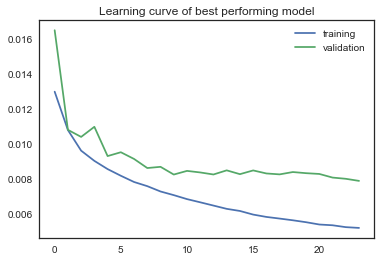

In [592]:
#Plot loss history
hist = res[np.argmin(losses)]["loss_history"]
plt.plot(hist.history["loss"][1:],label = "training")
plt.plot(hist.history["val_loss"][1:],label = "validation")
plt.title("Learning curve of best performing model")
plt.legend()
plt.show()

In the graph above, I plotted the learning curve of the best model and one can quickly see that the model is likely to overfit the data, which is why I will perform model ensembling in the next section in order to improve generalization.

## Model ensembling

[Model ensembling](https://en.wikipedia.org/wiki/Ensemble_learning) is a very powerful technique to increase accuracy on a variety of Machine Learning tasks. There are [various options](https://mlwave.com/kaggle-ensembling-guide/) to increase performance by combining different models to generate the final predictions. On the one hand there are simple but effective techniques such as averaging or voting, which do not require any retraining of models. Averaging works well for a wide range of problems and metrics. There is not much more to averaging than taking the mean of individual model predictions, which often reduces overfit. On the other hand, there are methods such as stacking and blending, where the basic idea is to use a pool of base models, then use another model to combine their predictions, with the aim of reducing the generalization error. However, these methods are more expensive to perform since they require retraining of the base models on k-folds of the training data.

Due to computational constraints on my local machine, I will use a simple averaging method. The final predictions will be generated by the 10 best performing models found during my optimization scheme above.

In [586]:
def ensemble_predict(model_list, X):
    y_preds = []
    for est in model_list:
        y_preds.append(est.predict(X).flatten())
    return np.mean( np.array(y_preds), axis=0 )

In [587]:
top_n = 10
idx = np.argsort(losses)[0:top_n]
model_list = [res[i]["model"] for i in idx]

#model_list = [model0,model1,model3]
preds = ensemble_predict(model_list, X_test)

In [588]:
ens_preds = log_max_inv(preds)
rescaled_targs = log_max_inv(y_test)
pred_df = pd.DataFrame({'preds':ens_preds.round(), 'y_true':rescaled_targs.round()})

## Evaluate performance & error analysis

In order to have a relatively reliable estimate of the "true" predictive capabilities of the final models, their performance has to be measured against an out-of-sample test set (i.e. holdout set for the period between 2015-05-01 and 2015-07-31). As already mentioned above the target metric to measure performance will be RMSPE.

In [595]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Encode categorical features (Usually one would do one-hot or dummy encoding, but as a benchmark labelencode is sufficient)
# Numerical features are also not scaled, since this is relevant to OLS regression performance
cat_maps = [(o, LabelEncoder()) for o in cat_features]
cat_mapper = DataFrameMapper(cat_maps)
cat_dat = cat_mapper.fit_transform(dat)
X = np.hstack([cat_dat, dat[num_features].as_matrix()])

_, feat_train, __, targ_train = train_test_split(X, dat[target].as_matrix(), 
                                                    test_size=0.8, shuffle = False) 
baseline = LinearRegression()
baseline.fit(feat_train,targ_train)

feat_test, _, targ_test, __= train_test_split(X, dat[target].as_matrix(), 
                                                    test_size=0.9, shuffle = False)
preds = baseline.predict(feat_test)
acc, deviations = rmspe(log_max_inv(preds),log_max_inv(targ_test))
print("RMSPE of a simple linear regression model as baseline: ",round(acc,4))

del X,feat_train,targ_train,feat_test,targ_test,_,__

RMSPE of a simple linear regression model as baseline:  0.4098


In [591]:
preds = best_model.predict(X_test).flatten()
single_preds = log_max_inv(preds)

acc, deviations = rmspe(single_preds,rescaled_targs)
print("RMSPE of strongest individual model: ",round(acc,4))

RMSPE of strongest individual model:  0.1496


In [590]:
acc, deviations = rmspe(ens_preds,rescaled_targs)
print("RMSPE of ensemble model: ",round(acc,4))

RMSPE of ensemble model:  0.1373


Serving as a simple baseline benchmark an additional linear regression model was trained. Looking at the results output above the linear model over- or underestimates the actual store sales by 41% on average. The rather poor performance of the linear model is not surprising due to its simplified assumption of linear relationships. The deep learning model that performed best after the optimization of hyperparameters achieves a much better performance of only 15% average forecasting error. Also as expected the ensemble of 10 deep learning models could boost the performance even further and achieve a **final forecasting error of only 13.73 %!**

In [608]:
#Get test dataframe
test_idx = list(pred_df.index)
test_dat = dat.iloc[test_idx,:]

In [621]:
#join predictions with additional data
test_dat = test_dat.reset_index()
test_dat = test_dat[["Date","Store", "DayOfWeek", 'StateName']]

In [645]:
p = pred_df.join(test_dat)
p["err"] = np.abs(p.preds-p.y_true)

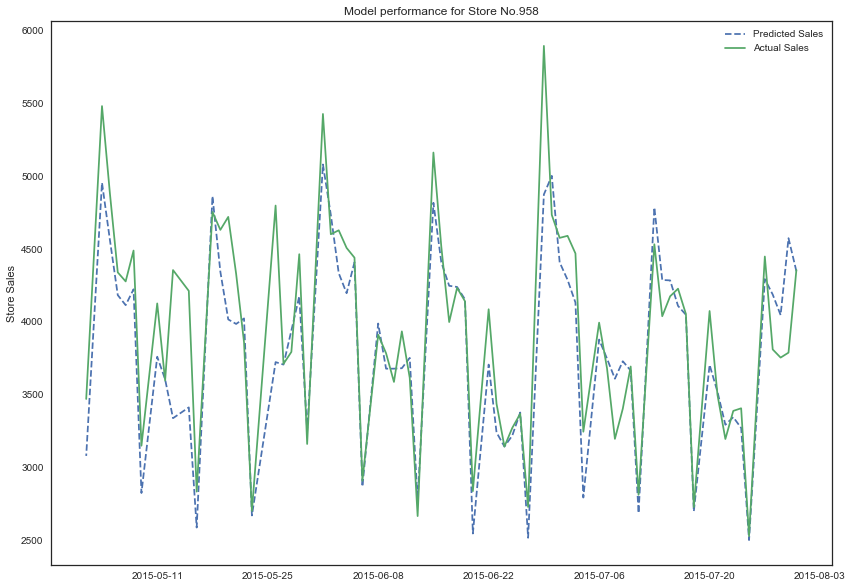

In [644]:
#Plot 10 day forecast and actuals for a particular store
#Plot loss history
p.index = p.Date
store_id = 958
sales_predictions = p.loc[(p["Store"]==store_id) & (p["y_true"]!=0),"preds"]
actual_sales = p.loc[(p["Store"]==store_id) & (p["y_true"]!=0),"y_true"]

plt.figure(figsize=(14,10))
plt.plot(sales_predictions,label = "Predicted Sales", linestyle = '--')
plt.plot(actual_sales,label = "Actual Sales")
plt.title("Model performance for Store No." + str(store_id))
plt.ylabel("Store Sales")
plt.legend()
plt.show()

The plot above proves that for many stores in the hold-out set, the model actually achieves a very good forecasting performance!

### Error analysis

Even though, the model has achieved a fairly decent performance, I still want to emphasize the fact that forecasting the future is a very hard challenge. There is no forecasting model that is perfect and therefore, it is crucial to understand a models limitations in particular, when it is being deployed for business critical tasks. Thus, I will highlight some particularly strong and strange forecasting erros belows.

In [647]:
pred_df[(pred_df["y_true"]==0.)&(pred_df["preds"]>2.)]

,preds,y_true
86825,6550.0,0.0


In [648]:
dat.iloc[86825,:5]

Store        971
DayOfWeek      5
Sales          0
Customers      0
Open           1
Name: 2015-05-15 00:00:00, dtype: object

Above, we can see the only case where the model predicted 6550 of sales even though there were no actual sales on that day in that particular store. However, this seems to be a strange case because when looking at some of the information for that day, we can quickly see that this store was actually open on that weekday. Hence, it is hard to believe that there was not a single sale. Therefore, I can only assume that this might be a data quality issue.

In [649]:
#Inspect the model errors and strengths
def get_worst_errors(preds, y_true, n = 10):
    idx = np.argsort(np.sqrt(np.square(preds-y_true)))
    idx = idx[::-1]
    idx = idx[0:n]
    return idx, pd.DataFrame({'preds':preds[idx].round(), 'y_true':y_true[idx].round()})

In [650]:
worst_idx,preds_df = get_worst_errors(rescaled_preds,rescaled_targs,n=10)
preds_df

,preds,y_true
0,9154.0,41551.0
1,9043.0,30038.0
2,8308.0,29161.0
3,19897.0,38367.0
4,9287.0,27330.0
5,8251.0,23584.0
6,9495.0,23927.0
7,20783.0,35159.0
8,8976.0,22882.0
9,9637.0,23081.0


Moreover, I looked at the 10 worst prediction errors above and clearly, in some rare cases the model drastically underestimates the actual sales. Subsequently, I got curious for which store ids, day of week and state the model has the largest trouble to come up with good sales forecasts.

In [686]:
#Plot RMSPE grouped by Store Id, day of week and state
p["rmspe"] = np.sqrt(np.square((p.preds-p.y_true)/p.y_true))

print("Worst mean forecasting performance:")
print()
for dim in ["Store","DayOfWeek",'StateName']:
    d = p.loc[p.y_true>0.,:].groupby(dim).mean().sort_values("rmspe",ascending = False).iloc[0]
    print(dim,":",str(d.name)+", ",round(d["rmspe"],4))

Worst mean forecasting performance:

Store : 91,  0.5155
DayOfWeek : 7,  0.1309
StateName : Bayern,  0.1119


The output above shows that especially for store 91, Sunday and Bavaria, the model has a harder time to come up with accurate sales predictions than for the other classes. Therefore, I could clearly identify some weaknesses of the forecasting model and by digging deeper into the special circumstances of store 91 for instance I could potentially further improve the model by engineering additional features or collecting more data.

## Visualize learned Entity Embeddings

As the neural network architecture is inspired by word embeddings, which encode [semantic meaning in their distributed representation](https://www.technologyreview.com/s/541356/king-man-woman-queen-the-marvelous-mathematics-of-computational-linguistics/), we can better understand what actual patterns the model learned by looking at its weights in greater detail.

Put differently, while learning to predict store sales the model has learned to map the discrete category features in a continuous space in which the distance between different "category points" reflects the similarity of the categories regarding their effect on store sales. To get an intuitive idea about the learned entity embeddings, I used t-SNE to map the high dimensional embeddings into a visualizable 2D figure. Below you can see the "sales similarity" between German states. The closer the points in the figure, the more similar they are.

In [691]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_entity_embeddings(model, feature_name, cat_features, encoding_mappings, figsize = (5,5), fontsize=12,random_state=None):
    
    idx = cat_features.index(feature_name)
    weight_matrix =model.get_weights()[idx]
    codes = encoding_mappings[feature_name]
    codes = {v: k for k, v in codes.items()} #Invert dictionary
    names = []
    print("Embeddings shape: ",weight_matrix.shape)
    
    for i in range(len(codes)):
        names.append(codes[i])

    if weight_matrix.shape[1]>2:
        #dim = TSNE(n_components = weight_matrix.shape[1], init='pca', method='exact',random_state=random_state)
        dim = PCA(random_state = random_state)
        W_embedded = dim.fit_transform(weight_matrix)
        y=-W_embedded[:,1]
        z=-W_embedded[:,0]
    else:
        y=weight_matrix[:,0]
        z=weight_matrix[:,1]
       
    #fig, ax = plt.subplots()
    plt.figure(figsize=figsize) 
    plt.scatter(z*-1.,y*-1.)
    eps_y = 0.01*y.max()
    eps_z = 0.01*z.max()

    for i, txt in enumerate(names):
        plt.annotate(txt, (z[i]*-1.+eps_z,y[i]*-1.)+eps_y,fontsize=fontsize)
    
    return plt

Embeddings shape:  (12, 6)


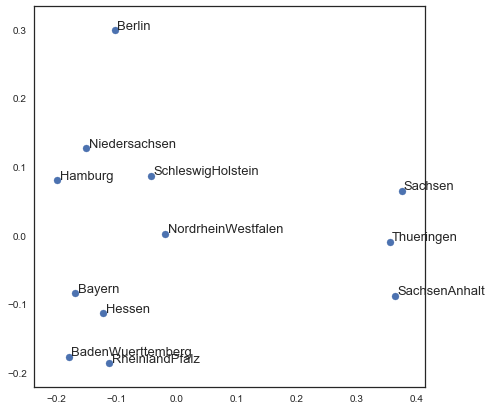

In [692]:
plt = plot_entity_embeddings(best_model, 'StateName', cat_features, encoding_mappings, figsize = (7,7), fontsize=13, 
                             random_state = 0)
plt.show()

Though the algorithm does not know anything about German geography and society, the relative positions on the learned embedding of German states resemble that on the below map reasonably well!

![](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2016/01/German_States.png)

The reason is that the learned embedding puts states with similar distribution of features, i.e. similar economical and cultural environments, close to each other, while at the same time two geographically neighboring states are likely sharing similar economy and culture. Especially, the three states on the right cluster, namely "Sachsen", "Thueringen" and "SachsenAnhalt" are all from eastern Germany while states in the left cluster are from western Germany. This shows the effectiveness of entity embeddings and their likely contribution to superior predictive performance.